In [39]:
import numpy as np
import cv2
from PIL import Image
import skimage
import matplotlib.pyplot as plt

(400, 400)


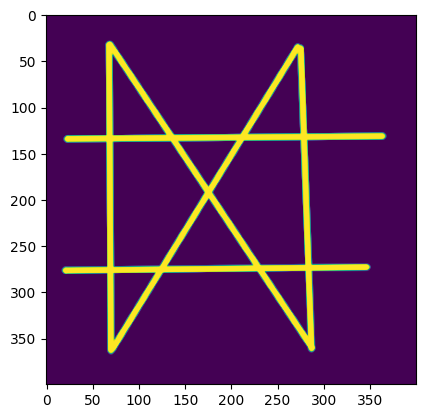

In [40]:
image = cv2.imread("../images/hough_line.jpg", flags=0)
print(image.shape)
plt.imshow(image)

# 霍夫线检测

## HoughLines 标准的霍夫变换,返回极坐标空间

一般情况是有经验的开发者使用，需要自己反变换到平面空间

In [41]:
hl = cv2.HoughLines(
    image=image,
    rho=1,              # 生成极坐标时候的像素扫描步长
    theta=np.pi / 180,  # 生成极坐标时候的角度步长，一般取值 pi/180
    threshold=150,      # 阈值，只有获得足够交点的极坐标点才被看成是直线
    srn=0,              # 是否应用多尺度的霍夫变换，如果不是设置0表示经典霍夫变换
    stn=0,              # 是否应用多尺度的霍夫变换，如果不是设置0表示经典霍夫变换
    min_theta=0,        # 表示角度扫描范围 0 ~180之间， 默认即可
    max_theta=np.pi,
)
print(hl.shape)
print(hl[0])

(69, 1, 2)
[[252.           0.55850536]]


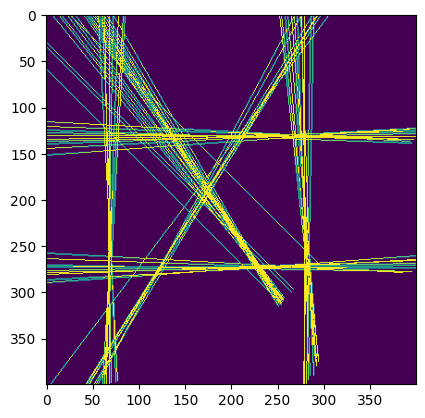

In [42]:
height, width = image.shape
detect = np.zeros(image.shape, dtype=np.uint8)
for h in hl:
    rho = h[0, 0]   # 极坐标中的r长度
    theta = h[0, 1] # 极坐标中的角度
    a = np.cos(theta)
    b = np.sin(theta)
    x = a * rho
    y = b * rho

    x1 = (x + width * (-b)).astype(np.int32)
    x2 = (x - width * (-b)).astype(np.int32)
    y1 = (y + height * a).astype(np.int32)
    y2 = (y - height * a).astype(np.int32)

    cv2.line(
        img=detect,
        pt1=(x1, y1),
        pt2=(x2, y2),
        color=255,
    )
plt.imshow(detect)

## HoughLinesP 输出是直线的两个点（x0,y0,x1,y1)

(400, 400)


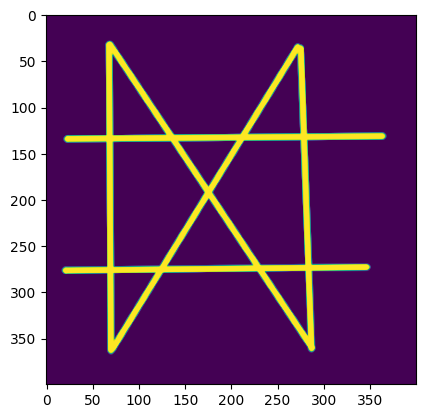

In [43]:
image1 = cv2.imread("../images/hough_line.jpg", flags=0)
print(image1.shape)
plt.imshow(image1)

In [44]:
hlp = cv2.HoughLinesP(
    image=image1,
    rho=1,              # 生成极坐标时候的像素扫描步长
    theta=np.pi / 180,  # 生成极坐标时候的角度步长，一般取值 pi/180
    threshold=150,      # 阈值，只有获得足够交点的极坐标点才被看成是直线
)
print(hlp.shape)

(119, 1, 4)


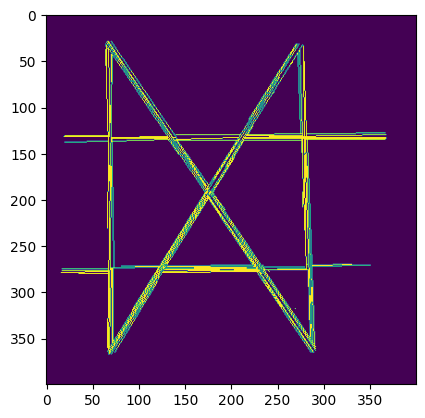

In [45]:
detect1 = np.zeros(image1.shape, dtype=np.uint8)
for h in hlp:
    x1 = h[0, 0]
    y1 = h[0, 1]
    x2 = h[0, 2]
    y2 = h[0, 3]

    cv2.line(
        img=detect1,
        pt1=(x1, y1),
        pt2=(x2, y2),
        color=255,
    )
plt.imshow(detect1)

# 霍夫圆检测

因为霍夫圆检测对噪声比较敏感，所以首先要对图像做中值滤波。

基于效率考虑，Opencv中实现的霍夫变换圆检测是基于图像梯度的实现，分为两步：

1. 检测边缘，发现可能的圆心
2. 基于第一步的基础上从候选圆心开始计算最佳半径大小

(400, 400)


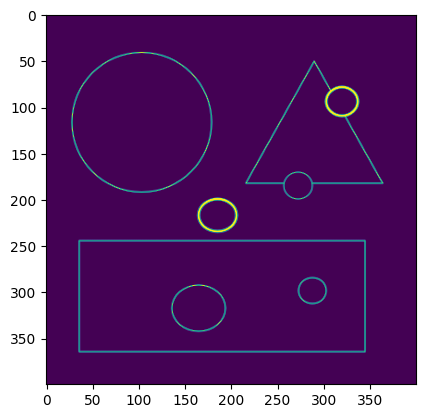

In [46]:
image2 = cv2.imread("../images/hough_circle.jpg", flags=0)
print(image2.shape)
plt.imshow(image2)

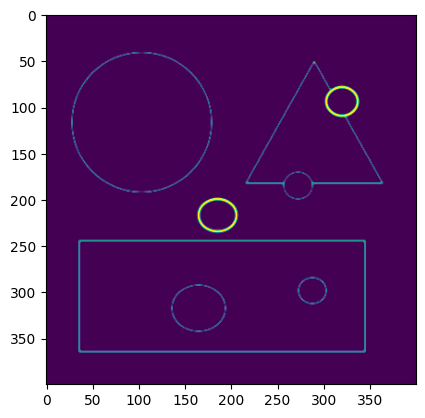

In [47]:
image_blur = cv2.medianBlur(
    src=image2,
    ksize=3
)
plt.imshow(image_blur)

In [48]:
hough_circles = cv2.HoughCircles(
    image=image_blur,           # image:    这是输入的灰度图像。圆环检测通常在灰度图像上执行，因为颜色信息对于圆的几何形状并不重要。
    method=cv2.HOUGH_GRADIENT,  # method:   指定霍夫变换的方法。对于圆环检测，这个方法通常是 cv2.HOUGH_GRADIENT 或者 HOUGH_GRADIENT_ALT。
    dp=1,                       # dp:       累加器的分辨率。累加器分辨率与图像分辨率成反比。例如，如果 dp=1 ，则累加器的分辨率与输入图像相同。如果 dp=2 ，则累加器的宽度和高度只有一半。对于HOUGH_GRADIENT_ALT，建议值为 dp=1.5，除非需要检测一些非常小的圆圈。
    minDist=20,                 # minDist:  这是检测到的圆环中心之间的最小距离。如果minDist太小，则会保留大部分圆心相近的圆。如果minDist太大，则会将圆心相近的圆进行合并（若两圆心距离 < minDist，则认为是同一个圆）。
    circles=None,               # circles:  用来保存找到的圆的，可以不设置
    param1=100,                 # param1:   在HOUGH_GRADIENT和HOUGH_GRADIENT_ALT的情况下，它是传递给 Canny 边缘检测器的两者中较高的阈值（较低的阈值的两倍）。
                                #           请注意，HOUGH_GRADIENT_ALT使用 Scharr 算法来计算图像导数，因此阈值通常应更高，例如 300 或正常曝光和对比度的图像。
    param2=33,                  # param2:   在HOUGH_GRADIENT的情况下，它是检测阶段圆心的累加器阈值。它越小，可能检测到的假圆圈就越多。将首先返回与较大的累加器值相对应的圆圈。
                                #           在HOUGH_GRADIENT_ALT算法的情况下，这是圆圈“完美性”度量。它越接近 1，算法选择的圆形形状越好。
                                #           在大多数情况下，0.9 应该没问题。如果你想更好地检测小圆圈，你可以把它降低到0.85、0.8甚至更少。
                                #           但随后也要尝试限制搜索范围 [minRadius， maxRadius] 以避免许多错误的圆圈。
    minRadius=5,                # minRadius: （可选）这是检测到的圆环的最小半径。可以帮助过滤掉小半径的圆环。
    maxRadius=None,             # maxRadius: （可选）这是检测到的圆环的最大半径。如果 <= 0，则使用最大图像尺寸。如果< 0，则HOUGH_GRADIENT返回中心而不找到半径。HOUGH_GRADIENT_ALT始终计算圆半径。
)
print(hough_circles.shape)

(1, 6, 3)


In [49]:
hough_circles

array([[[104.5, 116.5,  75.7],
        [184.5, 215.5,  18. ],
        [317.5,  93.5,  16.6],
        [161.5, 319.5,  25.2],
        [272.5, 184.5,  15.9],
        [285.5, 298.5,  14.3]]], dtype=float32)

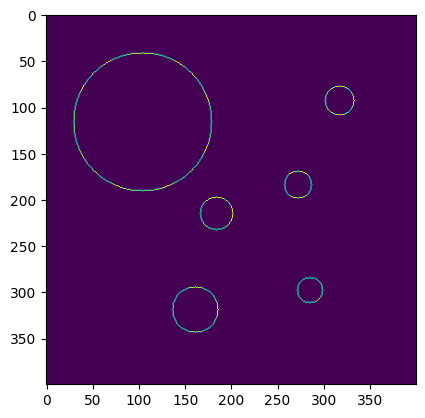

In [50]:
detect2 = np.zeros(image2.shape, dtype=np.uint8)
for hough_circle in hough_circles[0]:
    x = int(hough_circle[0])
    y = int(hough_circle[1])
    radius=int(hough_circle[2])

    cv2.circle(
        img=detect2,
        center=(x, y),
        radius=radius,
        color=255,
    )
plt.imshow(detect2)

In [51]:
hough_circles = cv2.HoughCircles(
    image=image_blur,           # image:    这是输入的灰度图像。圆环检测通常在灰度图像上执行，因为颜色信息对于圆的几何形状并不重要。
    method=cv2.HOUGH_GRADIENT_ALT,  # method:   指定霍夫变换的方法。对于圆环检测，这个方法通常是 cv2.HOUGH_GRADIENT 或者 HOUGH_GRADIENT_ALT。
    dp=1,                       # dp:       累加器的分辨率。累加器分辨率与图像分辨率成反比。例如，如果 dp=1 ，则累加器的分辨率与输入图像相同。如果 dp=2 ，则累加器的宽度和高度只有一半。对于HOUGH_GRADIENT_ALT，建议值为 dp=1.5，除非需要检测一些非常小的圆圈。
    minDist=20,                 # minDist:  这是检测到的圆环中心之间的最小距离。如果minDist太小，则会保留大部分圆心相近的圆。如果minDist太大，则会将圆心相近的圆进行合并（若两圆心距离 < minDist，则认为是同一个圆）。
    circles=None,               # circles:  用来保存找到的圆的，可以不设置
    param1=100,                 # param1:   在HOUGH_GRADIENT和HOUGH_GRADIENT_ALT的情况下，它是传递给 Canny 边缘检测器的两者中较高的阈值（较低的阈值的两倍）。
                                #           请注意，HOUGH_GRADIENT_ALT使用 Scharr 算法来计算图像导数，因此阈值通常应更高，例如 300 或正常曝光和对比度的图像。
    param2=0.1,                 # param2:   在HOUGH_GRADIENT的情况下，它是检测阶段圆心的累加器阈值。它越小，可能检测到的假圆圈就越多。将首先返回与较大的累加器值相对应的圆圈。
                                #           在HOUGH_GRADIENT_ALT算法的情况下，这是圆圈“完美性”度量。它越接近 1，算法选择的圆形形状越好。
                                #           在大多数情况下，0.9 应该没问题。如果你想更好地检测小圆圈，你可以把它降低到0.85、0.8甚至更少。
                                #           但随后也要尝试限制搜索范围 [minRadius， maxRadius] 以避免许多错误的圆圈。
    minRadius=5,                # minRadius: （可选）这是检测到的圆环的最小半径。可以帮助过滤掉小半径的圆环。
    maxRadius=None,             # maxRadius: （可选）这是检测到的圆环的最大半径。如果 <= 0，则使用最大图像尺寸。如果< 0，则HOUGH_GRADIENT返回中心而不找到半径。HOUGH_GRADIENT_ALT始终计算圆半径。
)
print(hough_circles.shape)

(1, 2, 3)


In [53]:
hough_circles

array([[[185.      , 213.      ,  19.312326],
        [320.      ,  92.      ,  16.560726]]], dtype=float32)

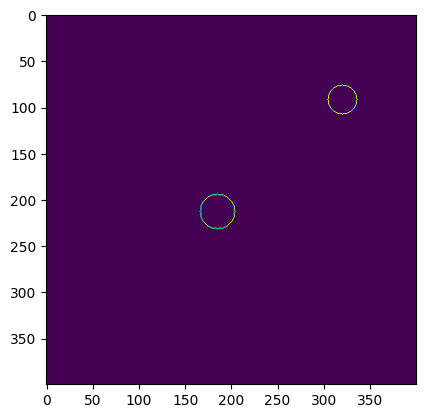

In [52]:
detect2 = np.zeros(image2.shape, dtype=np.uint8)
for hough_circle in hough_circles[0]:
    x = int(hough_circle[0])
    y = int(hough_circle[1])
    radius=int(hough_circle[2])

    cv2.circle(
        img=detect2,
        center=(x, y),
        radius=radius,
        color=255,
    )
plt.imshow(detect2)